In [1]:
import cv2
import numpy as np
 
def make_points(image, line):
    slope, intercept = line
    y1 = int(image.shape[0])# bottom of the image
    y2 = int(y1*3/5)         # slightly lower than the middle
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return [[x1, y1, x2, y2]]
 
def average_slope_intercept(image, lines):
    left_fit    = []
    right_fit   = []
    if lines is None:
        return None
    for line in lines:
        for x1, y1, x2, y2 in line:
            fit = np.polyfit((x1,x2), (y1,y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0: # y is reversed in image
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))

    if len(left_fit) and len(right_fit):
        left_fit_average  = np.average(left_fit, axis=0)
        right_fit_average = np.average(right_fit, axis=0)
        left_line  = make_points(image, left_fit_average)
        right_line = make_points(image, right_fit_average)
        averaged_lines = [left_line, right_line]
        return averaged_lines

def canny(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = 5
    blur = cv2.GaussianBlur(gray,(kernel, kernel),0)
    canny = cv2.Canny(gray, 50, 150)
    return canny
 
def display_lines(img,lines):
    line_image = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    return line_image
 
def region_of_interest(canny):
    height = canny.shape[0]
    width = canny.shape[1]
    mask = np.zeros_like(canny)
 
    triangle = np.array([[
    (200, height),
    (550, 250),
    (1100, height),]], np.int32)
 
    cv2.fillPoly(mask, triangle, 255)
    masked_image = cv2.bitwise_and(canny, mask)
    return masked_image

    image = cv2.imread('test_image.jpg')
    lane_image = np.copy(image)
    lane_canny = canny(lane_image)
    cropped_canny = region_of_interest(lane_canny)
    lines = cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100, np.array([]), minLineLength=40,maxLineGap=5)
    averaged_lines = average_slope_intercept(image, lines)
    line_image = display_lines(lane_image, averaged_lines)
    combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 0)

cap = cv2.VideoCapture("original.mp4")
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        canny_image = canny(frame)
        cropped_canny = region_of_interest(canny_image)
        lines = cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100, np.array([]), minLineLength=40,maxLineGap=5)
        averaged_lines = average_slope_intercept(frame, lines)
        line_image = display_lines(frame, averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
        cv2.imshow("result", combo_image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

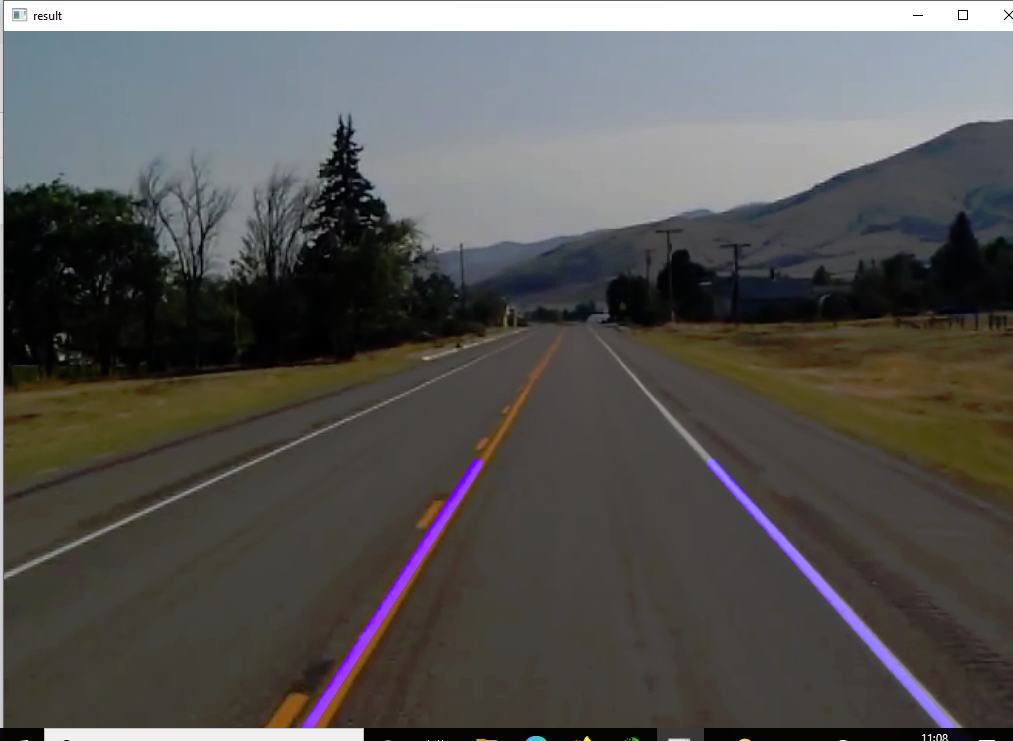